# Create Whatif Dataset

You may already have collected data in a tabular format, e.g., `.csv` or `.parquet` files. However,
you also need to *store* the *sar* information together with your tabular data. This is where
`whatif` dataset helps you: it provides a consistent format to organize your data files, the *sar*
information, and your custom metadata, as a single unit.

This notebook shows an example on how to convert your existing `.csv` data to a `whatif` dataset.
It covers the following steps:

- load source data into a pandas data frame
- preprocess the data frame to ensure the *sar* information is accurate
- wrap the pandas dataframe into a `WiDataFrame`
- save the `WiDataFrame` into the `whatif` dataset format

**NOTE**: as of this writing, `whatif` internally stores datasets as `.csv` files. Additional
formats will be added in the future.

**Pre-requisite:** this example requires [psychrolib](https://github.com/psychrometrics/psychrolib).
To quickly install this library, you may uncomment and execute the next cell. For more details,
please refer to its [documentation](https://github.com/psychrometrics/psychrolib#installation).

In [1]:
# %pip install pandas psychrolib

## Scenario

The source data has an existing root top unit (RTU) dataset which has the following states and
actions:

*States*
1) `outside_humidity`
2) `outside_temperature`
3) `return_humidity`
4) `return_temperature`

*Actions*

5) `economizer_enthalpy_setpoint`
6) `economizer_temperature_setpoint`

However, the source data does not have the reward column `power`. Hence, once we load the source
data, we pre-process it to add the `reward` column. Once the source data frame has completed its
*sar* columns, we can then save it as a `whatif` dataset.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pathlib import Path
from tempfile import mkdtemp

import numpy as np
import pandas as pd
import psychrolib

import a2rl as wi
from a2rl.nbtools import pprint, print  # Enable color outputs when rich is installed.

psychrolib.SetUnitSystem(psychrolib.IP)

# Fixed constant atm pressure, pressure data is not reliable with value (-0.1 to 0.1), unit: psi
PRESSURE = 14.696
# Assumption on design spec, can change to align with customer setting
SUPPLY_TEMP = 55
SUPPLY_REL_HUMIDITY = 0.5
SUPPLY_AIRFLOW = 8000
MIN_OUTSIDE_AIR_RATIO = 0.1

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/lightning_fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/pytorch_lightning/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:51: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  Bool8 = np.bool8
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:54: DeprecationWarning: `np.object0` is a deprecated alias for ``np.object0` is a deprecated alias for `np.object_`. `object` can be used instead.  (Deprecated NumPy 1.24)`.  (Deprecated NumPy 1.24)
  Object0 = np.object0
/opt/hostedtoolc

## Load source data

Let's start by loading a raw data source, which is a single `.csv` file. For simplicity, we re-use
the `data.csv` file from the sample `rtu` dataset. We won't load all the columns in this sample
`.csv` files, to simulate the missing reward columns.

In [3]:
source_csv_file = wi.sample_dataset_path("rtu") / "data.csv"
print(f"Load {source_csv_file} into a pandas dataframe, but without the power column.")
df = pd.read_csv(source_csv_file, usecols=lambda x: x != "power")

print(df.shape)
df.head()

Load /opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/a2rl/dataset/rtu/data.csv into a pandas dataframe, but without the power column.


(4335, 7)


timestamp  outside_humidity  outside_temperature   
0  2021-02-24 12:00:00              0.80                 64.6  \
1  2021-02-24 13:00:00              0.87                 77.0   
2  2021-02-24 14:00:00              0.99                 49.8   
3  2021-02-24 15:00:00              0.84                 81.8   
4  2021-02-24 16:00:00              0.82                 67.2   

   return_humidity  return_temperature  economizer_enthalpy_setpoint   
0             0.48                78.2                            72  \
1             0.42                76.8                            72   
2             0.51                71.8                            72   
3             0.49                75.7                            72   
4             0.53                77.0                            72   

   economizer_temperature_setpoint  
0                               30  
1                               30  
2                               30  
3                               30  
4                               30

## Calculate reward `power` column.

In [4]:
def get_enthalpy_from_temp_rh(temp, rh):
    humidity_ratio = psychrolib.GetHumRatioFromRelHum(temp, rh, PRESSURE)
    enthalpy = psychrolib.GetMoistAirEnthalpy(temp, humidity_ratio)
    return enthalpy


SUPPLY_ENTHALPY = get_enthalpy_from_temp_rh(SUPPLY_TEMP, SUPPLY_REL_HUMIDITY)

outside_enthalpy_list = []
return_enthalpy_list = []
for _, row in df.iterrows():
    out_ent = get_enthalpy_from_temp_rh(row["outside_temperature"], row["outside_humidity"])
    outside_enthalpy_list.append(out_ent)

    ret_ent = get_enthalpy_from_temp_rh(row["return_temperature"], row["return_humidity"])
    return_enthalpy_list.append(ret_ent)

df["outside_enthalpy"] = outside_enthalpy_list
df["return_enthalpy"] = return_enthalpy_list


def cal_power(
    outside_temperature,
    outside_enthalpy,
    return_temperature,
    return_enthalpy,
    max_enthalpy,
    max_temp,
):
    """
    data dict keys:
        max_enthalpy (agent's action/setting)
        max_temp (agent's action/setting)
        outside_temperature
        outside_enthalpy
        return_temperature
        return_enthalpy
    """
    data = {}
    data["outside_temperature"] = outside_temperature
    data["outside_enthalpy"] = outside_enthalpy
    data["return_temperature"] = return_temperature
    data["return_enthalpy"] = return_enthalpy

    # Only need to do when outside temp <= 55
    if data["outside_temperature"] <= 55:
        # print("Outside temperature is below cooling enable setpoint, no mechanical cooling ...")
        # raise ValueError("Outside temperature is below cooling enable setpoint")
        return 0

    # Determine econ on/off and get air ratio
    if data["outside_enthalpy"] > max_enthalpy or data["outside_temperature"] > max_temp:
        outside_air_ratio = MIN_OUTSIDE_AIR_RATIO
    else:
        outside_air_ratio = (data["return_temperature"] - SUPPLY_TEMP) / (
            data["return_temperature"] - data["outside_temperature"] + 1e-6
        )
        outside_air_ratio = np.clip(outside_air_ratio, MIN_OUTSIDE_AIR_RATIO, 1)

    # Determine enthaly to reach supply temp/RH
    economiser_mixed_air_enthalpy = (
        outside_air_ratio * data["outside_enthalpy"]
        + (1 - outside_air_ratio) * data["return_enthalpy"]
    )

    power = (economiser_mixed_air_enthalpy - SUPPLY_ENTHALPY) * 4.5 * SUPPLY_AIRFLOW

    return power


df["power"] = df.apply(
    lambda x: cal_power(
        x.outside_temperature,
        x.outside_enthalpy,
        x.return_temperature,
        x.return_enthalpy,
        x.economizer_enthalpy_setpoint,
        x.economizer_temperature_setpoint,
    ),
    axis=1,
)

print(df.shape)
df.head()

(4335, 10)


timestamp  outside_humidity  outside_temperature   
0  2021-02-24 12:00:00              0.80                 64.6  \
1  2021-02-24 13:00:00              0.87                 77.0   
2  2021-02-24 14:00:00              0.99                 49.8   
3  2021-02-24 15:00:00              0.84                 81.8   
4  2021-02-24 16:00:00              0.82                 67.2   

   return_humidity  return_temperature  economizer_enthalpy_setpoint   
0             0.48                78.2                            72  \
1             0.42                76.8                            72   
2             0.51                71.8                            72   
3             0.49                75.7                            72   
4             0.53                77.0                            72   

   economizer_temperature_setpoint  outside_enthalpy  return_enthalpy   
0                               30         26.812791        29.581856  \
1                               30         37.533514        27.437653   
2                               30         20.071088        26.465434   
3                               30         41.284553        28.309761   
4                               30         28.854091        29.961796   

           power  
0  401451.429676  
1  370573.856740  
2       0.000000  
3  412333.915992  
4  421110.171472

We can also plot the rewards.

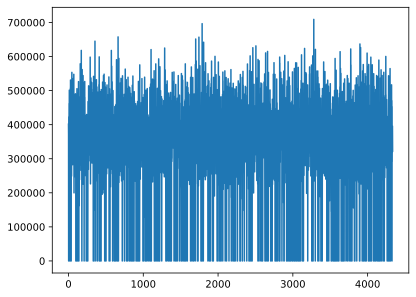

In [5]:
df["power"].plot();

## Save pandas Dataframe as `whatif` Dataset

Converting a pandas dataframe to a `whatif` dataset is straight forward: we just need to create a
`WiDataFrame`, then call its `to_csv_dataset()` method.

In [6]:
wdf = wi.WiDataFrame(
    df,
    states=["outside_humidity", "outside_temperature", "return_humidity", "return_temperature"],
    actions=["economizer_enthalpy_setpoint", "economizer_temperature_setpoint"],
    rewards=["power"],
)

display(wdf.sar_d, wdf.head())

{'states': ['outside_humidity',
  'outside_temperature',
  'return_humidity',
  'return_temperature'],
 'actions': ['economizer_enthalpy_setpoint',
  'economizer_temperature_setpoint'],
 'rewards': ['power']}

timestamp  outside_humidity  outside_temperature   
0  2021-02-24 12:00:00              0.80                 64.6  \
1  2021-02-24 13:00:00              0.87                 77.0   
2  2021-02-24 14:00:00              0.99                 49.8   
3  2021-02-24 15:00:00              0.84                 81.8   
4  2021-02-24 16:00:00              0.82                 67.2   

   return_humidity  return_temperature  economizer_enthalpy_setpoint   
0             0.48                78.2                            72  \
1             0.42                76.8                            72   
2             0.51                71.8                            72   
3             0.49                75.7                            72   
4             0.53                77.0                            72   

   economizer_temperature_setpoint  outside_enthalpy  return_enthalpy   
0                               30         26.812791        29.581856  \
1                               30         37.533514        27.437653   
2                               30         20.071088        26.465434   
3                               30         41.284553        28.309761   
4                               30         28.854091        29.961796   

           power  
0  401451.429676  
1  370573.856740  
2       0.000000  
3  412333.915992  
4  421110.171472

Now, we can directly save the `WiDataFrame` into a `whatif` dataset. For this example, we're going
to write the output to a temp directory, and our new dataset is going to include only the
`timestamp` and the *sar* columns.

In [7]:
# Will save to a temporary directory. Feel free to change to another location
outdir = Path(mkdtemp()) / "my-rtu-dataset"
print("Will save output dataset to", outdir)

# Let the dataset contains only the timestamp and sar columns.
wdf[["timestamp", *wdf.sar]].to_csv_dataset(outdir, index=False)

Will save output dataset to /tmp/tmp3siha99d/my-rtu-dataset


As shown below, a `whatif` dataset is a directory with a `metadata.yaml` file and a `data.csv` file.

In [8]:
!command -v tree &> /dev/null && tree -C --noreport {outdir} || ls -al {outdir}/*

/usr/bin/tree
/tmp/tmp3siha99d/my-rtu-dataset
├── data.csv
└── metadata.yaml


## Load the new Dataset

Now you can load the directory into a `WiDataFrame`.

In [9]:
df2 = wi.read_csv_dataset(outdir)
display(df2.shape, df2.sar, df2.head())

(4335, 8)

['outside_humidity',
 'outside_temperature',
 'return_humidity',
 'return_temperature',
 'economizer_enthalpy_setpoint',
 'economizer_temperature_setpoint',
 'power']

timestamp  outside_humidity  outside_temperature   
0  2021-02-24 12:00:00              0.80                 64.6  \
1  2021-02-24 13:00:00              0.87                 77.0   
2  2021-02-24 14:00:00              0.99                 49.8   
3  2021-02-24 15:00:00              0.84                 81.8   
4  2021-02-24 16:00:00              0.82                 67.2   

   return_humidity  return_temperature  economizer_enthalpy_setpoint   
0             0.48                78.2                            72  \
1             0.42                76.8                            72   
2             0.51                71.8                            72   
3             0.49                75.7                            72   
4             0.53                77.0                            72   

   economizer_temperature_setpoint          power  
0                               30  401451.429676  
1                               30  370573.856740  
2                               30       0.000000  
3                               30  412333.915992  
4                               30  421110.171472

We can also plot the rewards.

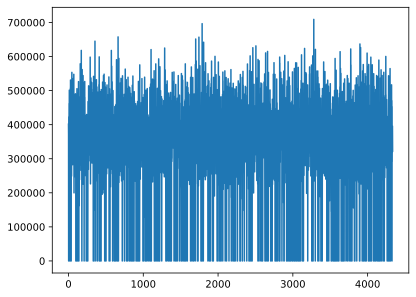

In [10]:
df2["power"].plot();

## Summary

Congratulations! You've completed the tutorial on `whatif` dataset. We encourage you to further
explore the remaining examples.